# Exploração dos Dados (SE/CO – Goiás)

Este notebook explora as features semanais do projeto (a partir dos CSVs diários do ONS e NASA) e analisa o alvo (classe de risco).

Pré‑requisitos:
- Ter gerado os CSVs diários em `data/raw/` (`python main.py data --incluir-meteorologia`)
- Opcional: gerar e salvar as features semanais (`python main.py features`)


In [1]:
# Imports básicos
import os, sys, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

# Tenta importar seaborn (opcional). Se não existir, seguimos com matplotlib.
try:
    import seaborn as sns
    _HAS_SNS = True
    sns.set_context('talk'); sns.set_style('whitegrid')
except Exception as e:
    print(f'[aviso] seaborn indisponível/incompatível: {e}')
    _HAS_SNS = False

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)

# Garantir import de 'src' subindo diretórios até encontrar a raiz do repo
repo_root = Path.cwd().resolve()
for _ in range(8):
    if (repo_root / 'src').exists():
        break
    repo_root = repo_root.parent
assert (repo_root / 'src').exists(), f"Não encontrei 'src' a partir de {Path.cwd()}"
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('repo_root:', repo_root)

from src.data_loader import load_all_sources
from src.feature_engineer import build_features_weekly
from src.train import rotular_semana, compute_label_thresholds


repo_root: D:\OneDrive\Documentos\Profissional\Pós IA IFG\Matérias\Trabalho Final Módulo 2\versaoGitHub


## Carregar configuração e dados
Carrega `configs/config.yaml`, garante `data/raw/` e tenta gerar automaticamente os CSVs ausentes (ONS + ETL + NASA).

In [2]:
# Lê configuração
cfg_path = repo_root / 'configs' / 'config.yaml'
cfg = yaml.safe_load(open(cfg_path, 'r', encoding='utf-8'))
# Garante caminho absoluto para data/raw baseado na raiz do repo
raw_dir = (repo_root / cfg['paths']['raw_dir']).resolve()
raw_dir.mkdir(parents=True, exist_ok=True)
# Atualiza o caminho no cfg para que load_all_sources use o diretório absoluto
cfg['paths']['raw_dir'] = str(raw_dir)

# Verifica se os CSVs diários esperados existem; se não, tenta gerá-los
expected = [
    raw_dir / 'ons_carga_diaria.csv',
    raw_dir / 'ons_geracao_fontes_diaria.csv',
    raw_dir / 'ons_intercambio_diario.csv',
    raw_dir / 'ons_ena_diaria.csv',
    raw_dir / 'ons_ear_diaria.csv',
    raw_dir / 'ons_cortes_eolica_diario.csv',
    raw_dir / 'ons_cortes_fv_diario.csv',
    raw_dir / 'clima_go_diario.csv',
]
missing = [p for p in expected if not p.exists()]
if missing:
    print(f"[dados] raw_dir: {raw_dir}")
    print('[dados] CSVs diários ausentes (exemplos):', [m.name for m in missing[:5]], '...')
    print('[dados] Tentando completar dados (ETL e, se necessário, download).')
    try:
        from src.fetch_ons import fetch_all
        from src import etl_ons
        from src.meteo import fetch_meteorologia
        since = (cfg.get('download', {}) or {}).get('since')
        # Caminhos brutos esperados para o ETL
        paths = {
            'balanco': raw_dir / 'ons_balanco_subsistema_horario.csv',
            'intercambio': raw_dir / 'ons_intercambios_entre_subsistemas_horario.csv',
            'carga': raw_dir / 'ons_carga.csv',
            'ena': raw_dir / 'ons_ena_diario_subsistema.csv',
            'ear': raw_dir / 'ons_ear_diario_subsistema.csv',
            'corte_eolica': raw_dir / 'ons_constrained_off_eolica_mensal.csv',
            'corte_fv': raw_dir / 'ons_constrained_off_fv_mensal.csv',
        }
        raw_required = list(paths.values())
        missing_raw = [p for p in raw_required if not p.exists()]
        if missing_raw:
            print('[dados] Arquivos brutos ausentes; baixando via CKAN (pode demorar)...')
            fetch_all(raw_dir, since=since, overwrite=False, verbose=True)
        # Sempre roda ETL (idempotente) para garantir os CSVs diários
        subm = 'SE/CO'
        etl_ons.etl_balanco_subsistema_horario(paths['balanco'], raw_dir, subm)
        etl_ons.etl_intercambio_horario(paths['intercambio'], raw_dir, subm)
        etl_ons.etl_carga(paths['carga'], raw_dir, subm)
        etl_ons.etl_ena_diaria(paths['ena'], raw_dir, subm)
        etl_ons.etl_ear_diaria(paths['ear'], raw_dir, subm)
        etl_ons.etl_constrained_off_mensal(paths['corte_eolica'], raw_dir, 'eolica', subm)
        etl_ons.etl_constrained_off_mensal(paths['corte_fv'], raw_dir, 'fv', subm)
        # Meteorologia: só baixa se CSV final não existir
        try:
            if not (raw_dir / 'clima_go_diario.csv').exists():
                fetch_meteorologia(raw_dir, provider='nasa_power')
        except Exception as e:
            print('[dados] NASA opcional falhou:', e)
    except Exception as e:
        print('[dados] Geração automática falhou. Rode no terminal: python main.py data --incluir-meteorologia')
        print('Erro:', e)

# Carrega diários e compõe semanais
data = load_all_sources(cfg)
Xw = build_features_weekly(data, cfg).dropna(axis=1, how='all')
Xw.head()


D:\OneDrive\Documentos\Profissional\Pós IA IFG\Matérias\Trabalho Final Módulo 2\versaoGitHub\src\feature_engineer.py:306: UserWarning: Removendo features semanais com baixa cobertura (<60%): ['corte_eolica_mwh__p05_w', 'corte_eolica_mwh__p95_w', 'corte_eolica_mwh_max_w', 'corte_eolica_mwh_mean_w', 'corte_eolica_mwh_min_w', 'corte_eolica_mwh_std_w', 'corte_eolica_mwh_sum_w', 'corte_fv_mwh__p05_w', 'corte_fv_mwh__p95_w', 'corte_fv_mwh_max_w', 'corte_fv_mwh_mean_w', 'corte_fv_mwh_min_w', 'corte_fv_mwh_std_w', 'corte_fv_mwh_sum_w']
  warnings.warn(


,carga_mwh_mean_w,carga_mwh_sum_w,carga_mwh_max_w,carga_mwh_min_w,carga_mwh_std_w,carga_mwh__p95_w,carga_mwh__p05_w,ger_hidreletrica_mwh_mean_w,ger_hidreletrica_mwh_sum_w,ger_hidreletrica_mwh_max_w,ger_hidreletrica_mwh_min_w,ger_hidreletrica_mwh_std_w,ger_hidreletrica_mwh__p95_w,ger_hidreletrica_mwh__p05_w,ger_eolica_mwh_mean_w,ger_eolica_mwh_sum_w,ger_eolica_mwh_max_w,ger_eolica_mwh_min_w,ger_eolica_mwh_std_w,ger_eolica_mwh__p95_w,ger_eolica_mwh__p05_w,ger_fv_mwh_mean_w,ger_fv_mwh_sum_w,ger_fv_mwh_max_w,ger_fv_mwh_min_w,ger_fv_mwh_std_w,ger_fv_mwh__p95_w,ger_fv_mwh__p05_w,ger_termica_mwh_mean_w,ger_termica_mwh_sum_w,ger_termica_mwh_max_w,ger_termica_mwh_min_w,ger_termica_mwh_std_w,ger_termica_mwh__p95_w,ger_termica_mwh__p05_w,import_mwh_mean_w,import_mwh_sum_w,import_mwh_max_w,import_mwh_min_w,import_mwh_std_w,import_mwh__p95_w,import_mwh__p05_w,export_mwh_mean_w,export_mwh_sum_w,export_mwh_max_w,export_mwh_min_w,export_mwh_std_w,export_mwh__p95_w,export_mwh__p05_w,ena_mwmed_mean_w,ena_mwmed_sum_w,ena_mwmed_max_w,ena_mwmed_min_w,ena_mwmed_std_w,ena_mwmed__p95_w,ena_mwmed__p05_w,ear_pct_mean_w,ear_pct_sum_w,ear_pct_max_w,ear_pct_min_w,...,saldo_importador_mwh_sum_w_r2w_mean,saldo_importador_mwh_sum_w_r2w_std,saldo_importador_mwh_sum_w_r4w_mean,saldo_importador_mwh_sum_w_r4w_std,margem_vs_carga_w_lag1w,margem_vs_carga_w_lag2w,margem_vs_carga_w_lag4w,margem_vs_carga_w_r2w_mean,margem_vs_carga_w_r2w_std,margem_vs_carga_w_r4w_mean,margem_vs_carga_w_r4w_std,reserve_margin_ratio_w_lag1w,reserve_margin_ratio_w_lag2w,reserve_margin_ratio_w_lag4w,reserve_margin_ratio_w_r2w_mean,reserve_margin_ratio_w_r2w_std,reserve_margin_ratio_w_r4w_mean,reserve_margin_ratio_w_r4w_std,ens_week_mwh_lag1w,ens_week_mwh_lag2w,ens_week_mwh_lag4w,ens_week_mwh_r2w_mean,ens_week_mwh_r2w_std,ens_week_mwh_r4w_mean,ens_week_mwh_r4w_std,ens_week_ratio_lag1w,ens_week_ratio_lag2w,ens_week_ratio_lag4w,ens_week_ratio_r2w_mean,ens_week_ratio_r2w_std,ens_week_ratio_r4w_mean,ens_week_ratio_r4w_std,lolp_52w_lag1w,lolp_52w_lag2w,lolp_52w_lag4w,lolp_52w_r2w_mean,lolp_52w_r2w_std,lolp_52w_r4w_mean,lolp_52w_r4w_std,corte_renovavel_mwh_sum_w_lag1w,corte_renovavel_mwh_sum_w_lag2w,corte_renovavel_mwh_sum_w_lag4w,corte_renovavel_mwh_sum_w_r2w_mean,corte_renovavel_mwh_sum_w_r2w_std,corte_renovavel_mwh_sum_w_r4w_mean,corte_renovavel_mwh_sum_w_r4w_std,ger_renovavel_mwh_sum_w_lag1w,ger_renovavel_mwh_sum_w_lag2w,ger_renovavel_mwh_sum_w_lag4w,ger_renovavel_mwh_sum_w_r2w_mean,ger_renovavel_mwh_sum_w_r2w_std,ger_renovavel_mwh_sum_w_r4w_mean,ger_renovavel_mwh_sum_w_r4w_std,ratio_corte_renovavel_w_lag1w,ratio_corte_renovavel_w_lag2w,ratio_corte_renovavel_w_lag4w,ratio_corte_renovavel_w_r2w_mean,ratio_corte_renovavel_w_r2w_std,ratio_corte_renovavel_w_r4w_mean,ratio_corte_renovavel_w_r4w_std
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766091.283286,5.362639e+06,802961.033,685747.503,43435.265804,802338.0878,699102.3840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1243.696571,8705.876000,1691.732000,636.463,477.640997,1683.387200,649.4926,126784.876286,887494.133999,130043.114,122552.021,2439.024883,129615.3248,123341.5058,15430.326429,108012.285,33487.749,-3842.865,12216.140789,30644.8410,-764.5668,57986.802714,405907.619,109441.140,14199.605,33484.226492,101832.9603,18770.5175,21432.534162,150027.739136,21761.270020,20817.960571,319.245218,21754.345996,20969.232678,30.458297,213.208076,31.404024,29.555575,...,-297895.3340,NaN,-297895.33400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,8705.876000,NaN,8705.876000,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2018-01-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810242.518714,5.671698e+06,845447.439,749387.484,32795.288685,842824.8417,763648.4472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974.443429,13821.104000,231

## Exploração dos dados
Visão geral: período coberto, colunas, missing, estatísticas e correlações.

In [3]:
print('Período semanal:', Xw.index.min(), '->', Xw.index.max(), f'({len(Xw)} semanas)')
print('Total de features:', Xw.shape[1])
miss = Xw.isna().mean().sort_values(ascending=False)
miss.head(20)


Período semanal: 2018-01-07 00:00:00+00:00 -> 2025-09-21 00:00:00+00:00 (403 semanas)
Total de features: 896


reserve_margin_ratio_w_lag4w    0.168734
margem_vs_carga_w_lag4w         0.168734
ens_week_ratio_lag4w            0.168734
ens_week_mwh_lag4w              0.168734
carga_mwh_max_w_lag4w           0.168734
carga_mwh__p95_w_lag4w          0.168734
carga_mwh__p05_w_lag4w          0.168734
carga_mwh_sum_w_lag4w           0.168734
carga_mwh_std_w_lag4w           0.168734
carga_mwh_mean_w_lag4w          0.168734
carga_mwh_min_w_lag4w           0.168734
ens_week_mwh_lag2w              0.163772
carga_mwh_max_w_lag2w           0.163772
reserve_margin_ratio_w_lag2w    0.163772
ens_week_ratio_lag2w            0.163772
margem_vs_carga_w_lag2w         0.163772
carga_mwh_mean_w_lag2w          0.163772
carga_mwh_std_w_lag2w           0.163772
carga_mwh_min_w_lag2w           0.163772
carga_mwh_sum_w_lag2w           0.163772
dtype: float64

In [4]:
# Estatísticas de colunas-chave (usa o que existir)
cols_key = [c for c in Xw.columns if c in [
    'margem_suprimento_w', 'margem_vs_carga_w', 'reserve_margin_ratio_w',
    'ens_week_mwh', 'ens_week_ratio', 'lolp_52w',
    'geracao_total_mwh_sum_w', 'import_total_mwh_sum_w', 'export_total_mwh_sum_w',
    'ear_pct_mean_w', 'ena_mwmed_mean_w', 'corte_renovavel_mwh_sum_w', 'ratio_corte_renovavel_w'
]]
(Xw[cols_key] if cols_key else Xw).describe().T


,count,mean,std,min,25%,50%,75%,max
ena_mwmed_mean_w,403.0,1.497580e+04,7535.917165,4.066844e+03,8.580762e+03,1.356401e+04,2.073306e+04,3.774308e+04
ear_pct_mean_w,403.0,5.932998e+01,17.325444,2.512416e+01,4.567824e+01,6.023232e+01,7.252198e+01,9.018607e+01
geracao_total_mwh_sum_w,403.0,6.013000e+06,679876.819409,1.739055e+06,5.555035e+06,5.989047e+06,6.448792e+06,8.031443e+06
import_total_mwh_sum_w,403.0,1.027000e+06,568578.085378,-5.057755e+05,6.042074e+05,1.008649e+06,1.399270e+06,2.277797e+06
export_total_mwh_sum_w,403.0,3.728799e+05,526501.308608,-7.848492e+05,-3.994609e+04,3.077423e+05,7.893382e+05,1.442118e+06
margem_suprimento_w,403.0,6.667121e+06,733000.736635,2.136912e+06,6.210115e+06,6.644593e+06,7.080468e+06,8.902049e+06
margem_vs_carga_w,339.0,-7.179262e+06,567519.020440,-8.991386e+06,-7.563267e+06,-7.118724e+06,-6.783523e+06,-2.793459e+06
reserve_margin_ratio_w,339.0,-5.164048e-01,0.021864,-7.399431e-01,-5.230868e-01,-5.123503e-01,-5.048307e-01,-3.013612e-01
ens_week_mwh,339.0,7.179262e+06,567519.020440,2.793459e+06,6.783523e+06,7.118724e+06,7.563267e+06,8.991386e+06
ens_week_ratio,339.0,5.164048e-01,0.021864,3.013612e-01,5.048307e-01,5.123503e-01,5.230868e-01,7.399431e-01


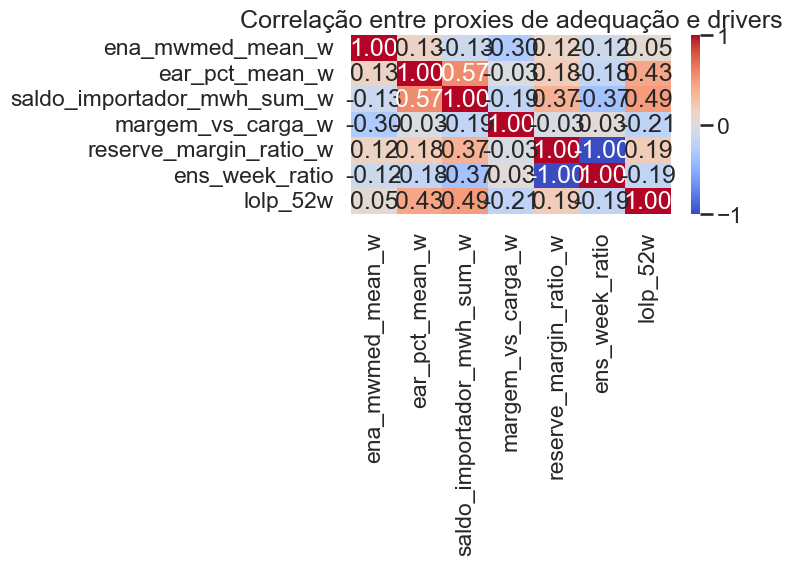

In [5]:
# Correlação entre proxies de adequação e drivers
corr_cols = [c for c in Xw.columns if c in [
    'margem_vs_carga_w', 'reserve_margin_ratio_w', 'ens_week_ratio', 'lolp_52w',
    'ear_pct_mean_w', 'ena_mwmed_mean_w', 'saldo_importador_mwh_sum_w',
]]
if corr_cols:
    corr = Xw[corr_cols].corr()
    plt.figure(figsize=(8,6))
    if _HAS_SNS:
        import seaborn as sns
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    else:
        im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        for (i, j), val in np.ndenumerate(corr.values):
            plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=9)
        plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
        plt.yticks(range(len(corr_cols)), corr_cols)
    plt.title('Correlação entre proxies de adequação e drivers')
    plt.tight_layout(); plt.show()
else:
    print('Sem colunas suficientes para matriz de correlação selecionada.')


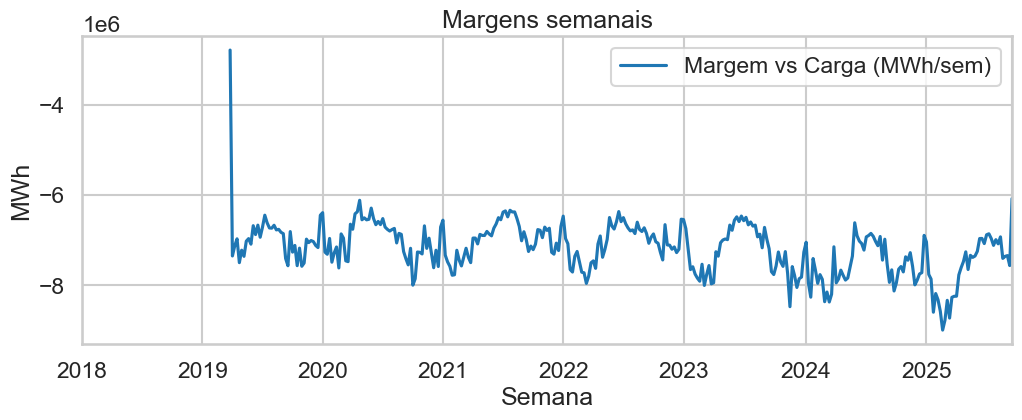

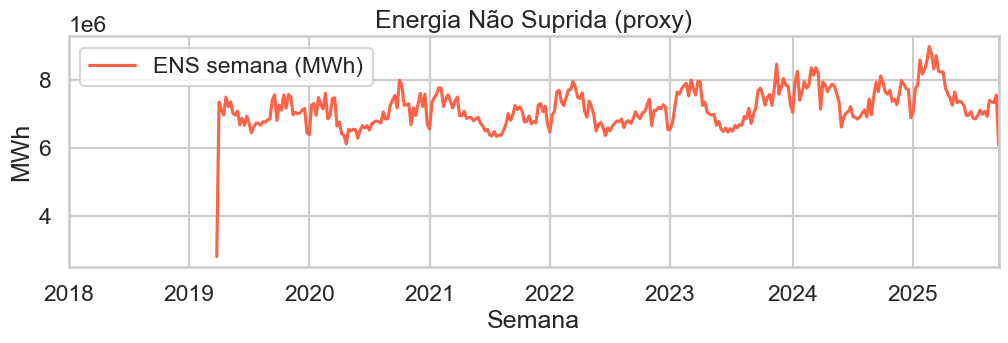

In [6]:
# Séries temporais de margens e ENS (se existirem)
plt.figure(figsize=(12,4))
if 'margem_vs_carga_w' in Xw.columns:
    Xw['margem_vs_carga_w'].plot(label='Margem vs Carga (MWh/sem)')
elif 'margem_suprimento_w' in Xw.columns:
    Xw['margem_suprimento_w'].plot(label='Margem de Suprimento (MWh/sem)')
plt.legend(); plt.title('Margens semanais'); plt.xlabel('Semana'); plt.ylabel('MWh'); plt.show()

if 'ens_week_mwh' in Xw.columns:
    plt.figure(figsize=(12,3))
    Xw['ens_week_mwh'].plot(color='tomato', label='ENS semana (MWh)')
    plt.legend(); plt.title('Energia Não Suprida (proxy)'); plt.xlabel('Semana'); plt.ylabel('MWh'); plt.show()


## Analisando o Alvo (target)
Geração do rótulo semanal (baixo|médio|alto) segundo as regras configuradas e análise de distribuição/temporalidade.

In [7]:
# Calcula thresholds a partir de todo o histórico (ou poderia usar apenas treino)
thr = compute_label_thresholds(cfg, Xw)
y = rotular_semana(Xw, cfg, ref_df=Xw)
H = int(cfg.get('problem', {}).get('forecast_horizon_weeks', 1))
if H > 0:
    y = y.shift(-H)
y = y.dropna()
print('Semanas rotuladas:', len(y))
y.value_counts()


Semanas rotuladas: 373


alto     166
baixo    165
medio     42
Name: count, dtype: int64

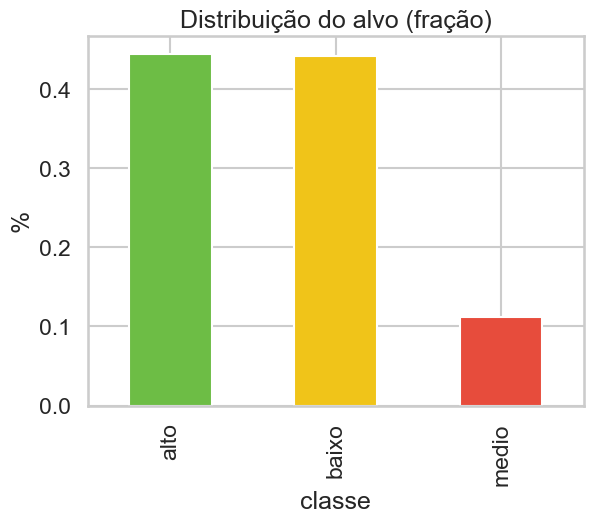

alto     0.445040
baixo    0.442359
medio    0.112601
Name: proportion, dtype: float64

In [8]:
# Distribuição de classes (fração)
vc = y.value_counts(normalize=True).sort_index()
ax = vc.plot(kind='bar', color=['#6dbd45','#f0c419','#e74c3c'])
ax.set_title('Distribuição do alvo (fração)'); ax.set_xlabel('classe'); ax.set_ylabel('%');
plt.show(); vc


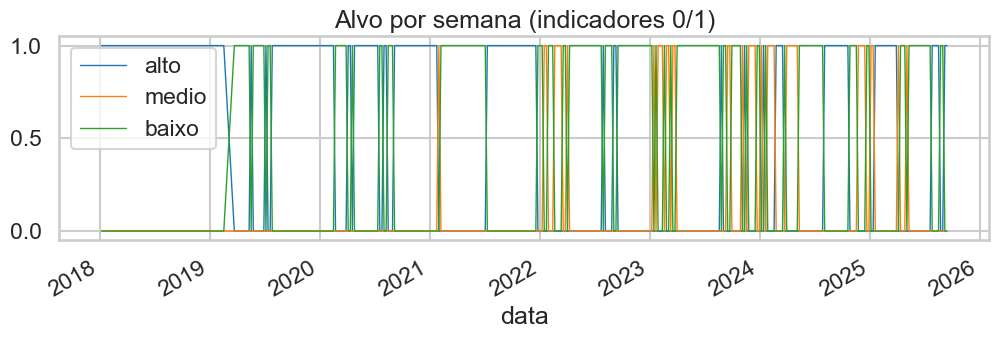

In [9]:
# Alvo ao longo do tempo (indicadores 0/1)
fig, ax = plt.subplots(figsize=(12,3))
(y=='alto').astype(int).plot(ax=ax, lw=1, label='alto')
(y=='medio').astype(int).plot(ax=ax, lw=1, label='medio')
(y=='baixo').astype(int).plot(ax=ax, lw=1, label='baixo')
ax.set_title('Alvo por semana (indicadores 0/1)'); ax.legend(); plt.show()


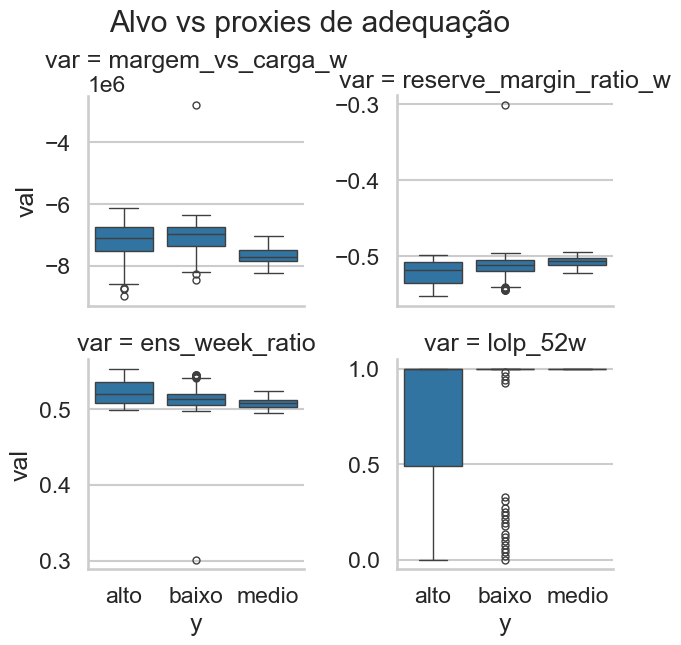

In [10]:
# Relação do alvo com proxies de adequação (boxplots)
dfy = pd.DataFrame({'y': y})
for col in ['margem_vs_carga_w','reserve_margin_ratio_w','ens_week_ratio','lolp_52w']:
    if col in Xw.columns:
        dfy[col] = Xw[col].reindex(dfy.index)
melted = dfy.melt('y', var_name='var', value_name='val')
vars_ = melted['var'].unique()
if len(vars_) == 0:
    print('Sem proxies disponíveis para plotar contra o alvo.')
elif _HAS_SNS:
    import seaborn as sns
    sns.catplot(data=melted, x='y', y='val', col='var', kind='box', sharey=False, col_wrap=2, height=3.2)
    plt.suptitle('Alvo vs proxies de adequação', y=1.02); plt.show()
else:
    n = len(vars_)
    cols = 2
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3.2*rows), squeeze=False)
    for idx, var in enumerate(vars_):
        ax = axes[idx//cols][idx%cols]
        sub = melted[melted['var']==var]
        classes = sorted(sub['y'].unique())
        groups = [sub[sub['y']==cl]['val'].dropna().values for cl in classes]
        ax.boxplot(groups, labels=classes)
        ax.set_title(var); ax.set_xlabel('classe'); ax.set_ylabel('valor')
    plt.suptitle('Alvo vs proxies de adequação'); plt.tight_layout(); plt.show()


### Thresholds usados
Valores de referência calculados (e persistíveis) para a rotulagem.

In [11]:
import pprint
pprint.pprint(thr)


{'curtail': {'ratio_thr': 0.05, 'requer_saldo_importador_nao_positivo': True},
 'ear': {'col': 'ear_pct_mean_w',
         'q_baixo': 0.2,
         'q_baixo_value': 39.90887425321428},
 'ena': {'col': 'ena_mwmed_mean_w',
         'janelas_consecutivas': 2,
         'q_baixo': 0.2,
         'q_baixo_value': 7669.641469964},
 'margem': {'col': 'margem_vs_carga_w',
            'q_baixo': 0.05,
            'q_baixo_value': -8127815.645723188,
            'q_medio': 0.2,
            'q_medio_value': -7619572.681001262},
 'meta': {'train_end': '2025-09-21 00:00:00+00:00',
          'train_start': '2018-01-07 00:00:00+00:00'},
 'regulatory_proxies': {'ens_ratio_thr': 0.05,
                        'ens_ratio_value': 0.5437579097164895,
                        'lolp_thr': 0.05,
                        'lolp_value': 1.0,
                        'reserva_operativa_frac': 0.05,
                        'reserva_operativa_value': -0.5437579097164895,
                        'usar_regras_duras': True}